<a href="https://colab.research.google.com/github/zxyao5148/STAT3612_2023_1A_GroupProject/blob/main/RNN_Transformer/RNN_selected_feat_median.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates how to do timeseries classification using RNN models (Simple RNN, LSTM, and GRU).

Reference: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Load the dataset

In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np

# Raw URLs for the CSV files
train_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/train/selected_feat/train_median.csv"
test_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/valid/selected_feat/valid_median.csv"

# Download the CSV files
train_csv = requests.get(train_url).text
test_csv = requests.get(test_url).text

# Read the CSV files into pandas DataFrames
train = pd.read_csv(StringIO(train_csv))
test = pd.read_csv(StringIO(test_csv))

# Split the data into features (X) and target variable (y)
#x_train = train.iloc[:, train.columns != train.columns[4]]  # Select all columns except the fourth one as features
x_train = train.iloc[:,5:]
y_train = train.iloc[:, 4]                                 # Select the fourth column as the target variable

#x_test = test.iloc[:, test.columns != test.columns[4]]     # Select all columns except the fourth one as features
x_test = test.iloc[:,5:]
y_test = test.iloc[:, 4]                                   # Select the fourth column as the target variable

In [2]:
x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

In [3]:
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU, SimpleRNN
from keras.models import Sequential
from keras import optimizers
import keras

# Simple RNN

In [4]:
# Note: replace RNN with GRU or RNN if you want to try those
# In Keras, the "RNN" layer is a wrapper for the RNN cell, not the actual cell itself.
#specify the type of RNN cell to use, such as LSTM, GRU, or SimpleRNN

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=False, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy"])

print ('model compiled')

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

print (model.summary())

#Train the model
history_RNN=model.fit(x_train, y_train, batch_size=512, epochs=200, validation_data = (x_test, y_test), callbacks=callbacks)

model compiled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100, 50)           2600      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               15100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 17801 (69.54 KB)
Trainable params: 17801 (69.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


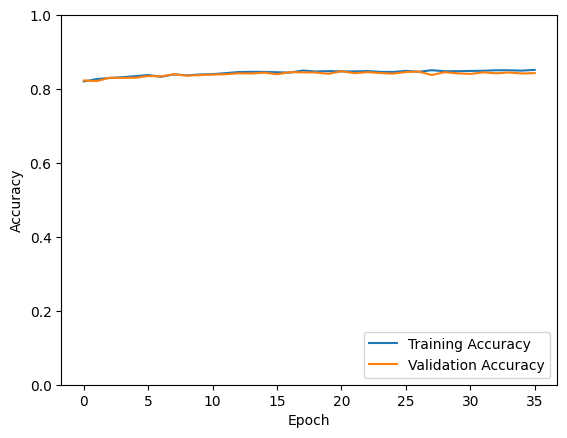

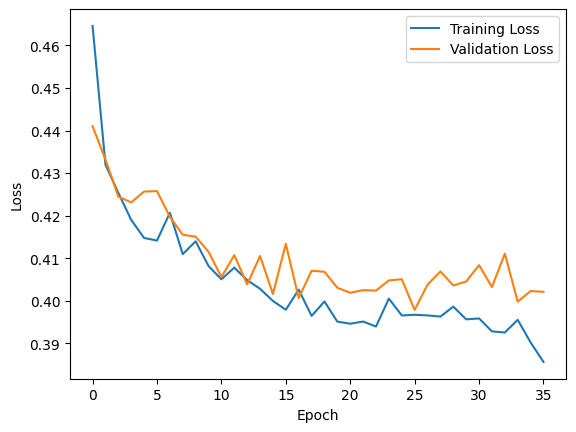

In [5]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_RNN.history['accuracy'], label='Training Accuracy')
plt.plot(history_RNN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_RNN.history['loss'], label='Training Loss')
plt.plot(history_RNN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


##Evaluation

In [6]:
from sklearn.metrics import roc_auc_score

y_train_pred = model.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = np.argmax(y_train_pred, axis=1) # Choose the class with the highest probability
y_test_pred = model.predict(x_test)
y_test_pred_binary = np.argmax(y_test_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_test = accuracy_score(y_test, y_test_pred_binary)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (test): {accuracy_test:.4f}')
print(f'AUC (test): {auc_test:.4f}')

73/73 [==============================] - 2s 28ms/step
Accuracy (train): 0.8253
AUC (train): 0.7542
Accuracy (test): 0.8228
AUC (test): 0.7377


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_binary, zero_division=1)
recall = recall_score(y_test, y_test_pred_binary, zero_division=1)
f1 = f1_score(y_test, y_test_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For testing set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

For training set:
Precision: 1.0
Recall: 0.0
F1 Score: 0.0 

For testing set:
Precision: 1.0
Recall: 0.0
F1 Score: 0.0


# LSTM

In [8]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(100, return_sequences=False, activation="relu"))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1, activation="sigmoid"))  # Changed activation function

model_LSTM.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

print('model compiled')

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

print(model_LSTM.summary())

#Train the model
history_LSTM=model_LSTM.fit(x_train, y_train, batch_size=512, epochs=200, validation_data = (x_test, y_test), callbacks=callbacks)

model compiled
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 70901 (276.96 KB)
Trainable params: 70901 (276.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

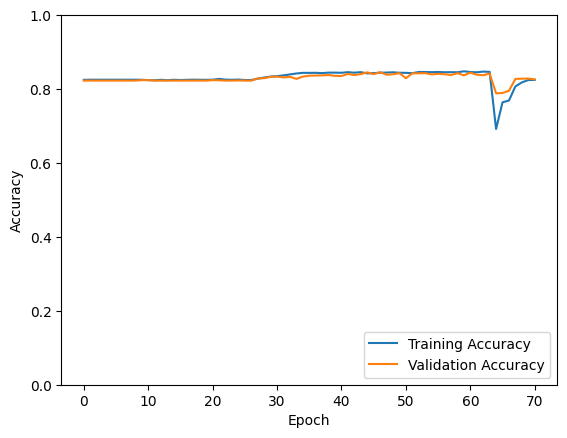

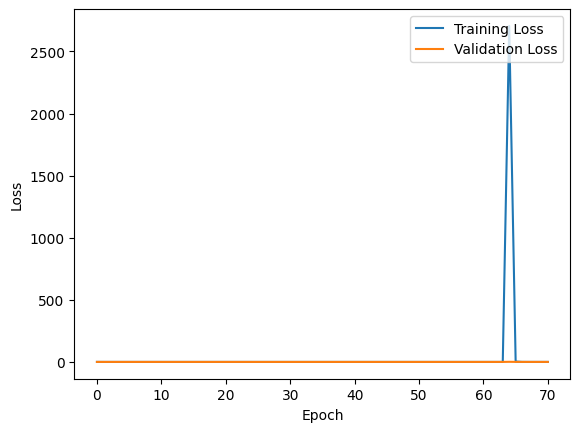

In [9]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_LSTM.history['accuracy'], label='Training Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


##Evaluation

In [10]:
from sklearn.metrics import roc_auc_score

y_train_pred = model_LSTM.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = np.argmax(y_train_pred, axis=1) # Choose the class with the highest probability
y_test_pred = model_LSTM.predict(x_test)
y_test_pred_binary = np.argmax(y_test_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_test = accuracy_score(y_test, y_test_pred_binary)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (test): {accuracy_test:.4f}')
print(f'AUC (test): {auc_test:.4f}')

73/73 [==============================] - 1s 17ms/step
Accuracy (train): 0.8253
AUC (train): 0.7211
Accuracy (test): 0.8228
AUC (test): 0.7144


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_binary, zero_division=1)
recall = recall_score(y_test, y_test_pred_binary, zero_division=1)
f1 = f1_score(y_test, y_test_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For testing set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

For training set:
Precision: 1.0
Recall: 0.0
F1 Score: 0.0 

For testing set:
Precision: 1.0
Recall: 0.0
F1 Score: 0.0


# GRU

In [12]:
model_GRU = Sequential()
model_GRU.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(64, return_sequences=False, activation='relu'))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(1, activation = "sigmoid"))

model_GRU.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy"])

print('model compiled')

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

print(model_GRU.summary())

#Train the model
history_GRU=model_GRU.fit(x_train, y_train, batch_size=512, epochs=200, validation_data = (x_test, y_test), callbacks=callbacks)

model compiled
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           7950      
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                22272     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 30287 (118.31 KB)
Trainable params: 30287 (118.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

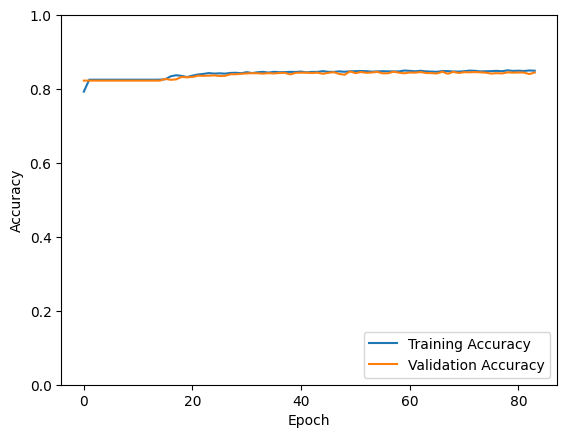

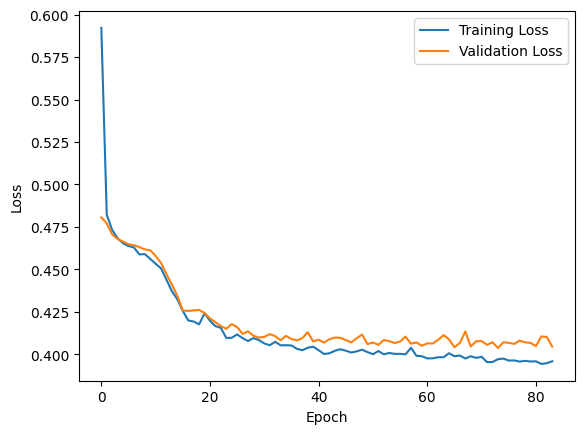

In [13]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_GRU.history['accuracy'], label='Training Accuracy')
plt.plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

##Evaluation

In [14]:
from sklearn.metrics import roc_auc_score

y_train_pred = model_GRU.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = np.argmax(y_train_pred, axis=1) # Choose the class with the highest probability
y_test_pred = model_GRU.predict(x_test)
y_test_pred_binary = np.argmax(y_test_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_test = accuracy_score(y_test, y_test_pred_binary)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (test): {accuracy_test:.4f}')
print(f'AUC (test): {auc_test:.4f}')

73/73 [==============================] - 1s 19ms/step
Accuracy (train): 0.8253
AUC (train): 0.7369
Accuracy (test): 0.8228
AUC (test): 0.7248


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_binary, zero_division=1)
recall = recall_score(y_test, y_test_pred_binary, zero_division=1)
f1 = f1_score(y_test, y_test_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For testing set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

For training set:
Precision: 1.0
Recall: 0.0
F1 Score: 0.0 

For testing set:
Precision: 1.0
Recall: 0.0
F1 Score: 0.0
